# **Arpitha Gurumurthy**
### *CMPE 257 Assignment 2 - Clustering using GMM and Birch*
***Dataset : eCommerce customer behavior data***

https://www.kaggle.com/mkechinov/ecommerce-events-history-in-cosmetics-shop

# **Data collection and preparation**

In [ ]:
from io import BytesIO
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.cluster import KMeans
import seaborn as sns
import tensorflow.compat.v1 as tf
r = requests.get('https://docs.google.com/spreadsheets/d/e/2PACX-1vSeWSxz1oBPOdGhPbX6w7B30nP9TU3lawhzM6rbhiPcnYmyJ_Kv93AEfQL5I-JkfEm5-nDjEUNyVwkT/pub?gid=288094237&single=true&output=csv')
data = r.content
df_Dec = pd.read_csv(BytesIO(data))
df_Dec = df_Dec.drop(columns='Unnamed: 0', axis=1)

In [ ]:
df_Dec.shape

(50000, 9)

# **Data wrangling**

In [ ]:
df_Dec.isnull().sum()

event_time           0
event_type           0
product_id           0
category_id          0
category_code    49144
brand            21941
price                0
user_id              0
user_session        15
dtype: int64

### **Column: category_code**

In [ ]:
##Counting the number of nan values in category_code column
df_Dec['category_code'].isnull().sum()

49144

In [ ]:
##Drop column category_code since the number of nulls is too huge
df_Dec = df_Dec.drop(columns='category_code', axis=1)

### **Column: brand**

In [ ]:
##Replace all null values 
df_Dec.brand = df_Dec.brand.replace(np.nan,'Not Available')

In [ ]:
df_Dec.isnull().sum()

event_time       0
event_type       0
product_id       0
category_id      0
brand            0
price            0
user_id          0
user_session    15
dtype: int64

### **Column: event_time**

In [ ]:
##Converting the date type to datetime type for 'event_time'
df_Dec['event_time'] = pd.to_datetime(df_Dec['event_time'], format='%Y-%m-%d %H:%M:%S UTC')

In [ ]:
##Splitting event_time into 2 columns containing date and time respectively
df_Dec['transaction_time'] = df_Dec['event_time'].dt.time
df_Dec['transaction_date'] = df_Dec['event_time'].dt.normalize()

### **product_id**

In [ ]:
type(df_Dec['product_id'][2])

numpy.int64

In [ ]:
## Counting how many unique products are in the dataset
print('The total count for product id is:',df_Dec['product_id'].count())
print('The total count for product id is:',len(df_Dec['product_id'].unique()))

The total count for product id is: 50000
The total count for product id is: 12964


### **user_id**

In [ ]:
## Counting how many unique products are in the dataset
print('The total count for user id is:',df_Dec['user_id'].count())
print('The total count for user id is:',len(df_Dec['user_id'].unique()))

The total count for user id is: 50000
The total count for user id is: 7292


### **price**

In [ ]:
df_Dec['price'].describe()

count    50000.000000
mean         8.543152
std         20.043783
min          0.000000
25%          1.730000
50%          3.970000
75%          6.350000
max        327.780000
Name: price, dtype: float64

### **user_session**

In [ ]:
df_Dec.user_session = df_Dec.user_session.replace(np.nan,'Not Available')

In [ ]:
df_Dec.isnull().sum()

event_time          0
event_type          0
product_id          0
category_id         0
brand               0
price               0
user_id             0
user_session        0
transaction_time    0
transaction_date    0
dtype: int64

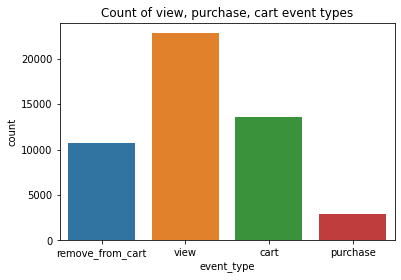

In [ ]:
#Count of event types
plt.title('Count of view, purchase, cart event types')
sns.countplot(x = 'event_type', data = df_Dec)

The data looks quite balanced.

# **EDA**

In [ ]:
sns.set(style="ticks")
numcols = ['user_id', 'product_id', 'category_id', 'price']
catcols = ['event_type','brand']
# Subset the columns
plot_df = df_Dec[numcols+ catcols]
# Few rows of data
plot_df.head()

,user_id,product_id,category_id,price,event_type,brand
0,576802932,5712790,1487580005268456287,6.27,remove_from_cart,f.o.x
1,412120092,5764655,1487580005411062629,29.05,view,cnd
2,494077766,4958,1487580009471148064,1.19,cart,runail
3,348405118,5848413,1487580007675986893,0.79,view,freedecor
4,576005683,5824148,1487580005511725929,5.56,view,Not Available


In [ ]:
!pip install dython
from dython import nominal

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:4327: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  downcast=downcast,


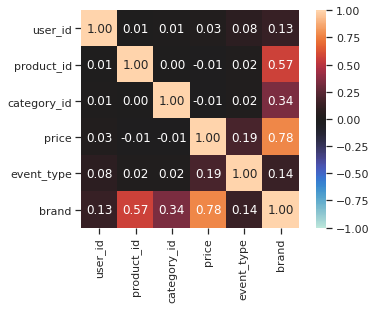

{'ax': <matplotlib.axes._subplots.AxesSubplot at 0x7f11762dfc88>,
 'corr':               user_id  product_id  category_id     price  event_type     brand
 user_id      1.000000    0.006763     0.013303  0.029179    0.081753  0.131367
 product_id   0.006763    1.000000     0.000979 -0.009795    0.020341  0.568457
 category_id  0.013303    0.000979     1.000000 -0.013430    0.021808  0.340815
 price        0.029179   -0.009795    -0.013430  1.000000    0.190350  0.777730
 event_type   0.081753    0.020341     0.021808  0.190350    1.000000  0.139854
 brand        0.131367    0.568457     0.340815  0.777730    0.139854  1.000000}

In [ ]:
nominal.associations(plot_df, nominal_columns=catcols)

We can see that the correlation between price and brand is the highest and the correlation between brand and product id is the second highest. There is a considerable correlation between category id and brand as well.

**Filter out events that are purchase to find the total amount spent per user**

In [ ]:
df_purchase = df_Dec[df_Dec["event_type"] == "purchase"]

In [ ]:
## We are calculating the total amount spent by each customer.
df1 = df_purchase.groupby(['user_id']).agg({'price': 'sum'}).reset_index()

Text(0.5, 1.0, 'Scatter plot for user spending behaviour')

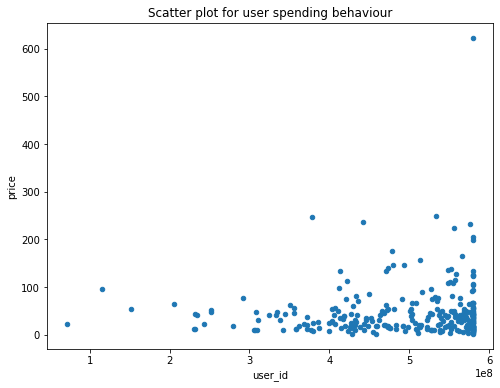

In [ ]:
df1.plot.scatter(x='user_id', y='price', figsize=(8,6))
plt.title("Scatter plot for user spending behaviour")

# **K-Means using scikitLearn**
We are clustering the users based on their spending behaviour. As shown above, we've computed the total amount spent by each user and stored in a dataframe called df1. 
We then plot the total amount against their respective user_id.

In [ ]:
# standardizing the data
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
data_scaled = scaler.fit_transform(df1)

# statistics of scaled data
pd.DataFrame(data_scaled).describe()

,0,1
count,2.900000e+02,2.900000e+02
mean,-2.825326e-16,-7.656711e-18
std,1.001729e+00,1.001729e+00
min,-4.372166e+00,-8.158460e-01
25%,-6.168880e-01,-5.459900e-01
50%,3.818315e-01,-2.531101e-01
75%,8.565004e-01,1.110449e-01
max,8.824341e-01,1.036998e+01


Text(0, 0.5, 'Inertia')

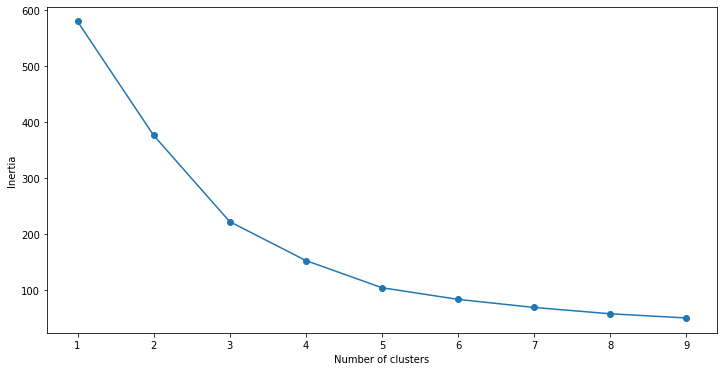

In [ ]:
# fitting multiple k-means algorithms and storing the values in an empty list
SSE = []
for cluster in range(1,10):
    kmeans = KMeans(n_jobs = -1, n_clusters = cluster, init='k-means++')
    kmeans.fit(data_scaled)
    SSE.append(kmeans.inertia_)

# converting the results into a dataframe and plotting them
frame = pd.DataFrame({'Cluster':range(1,10), 'SSE':SSE})
plt.figure(figsize=(12,6))
plt.plot(frame['Cluster'], frame['SSE'], marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')

In [ ]:
#Trying out 4 clusters decided from the above elbow plot
kmeans = KMeans(n_clusters=3)
kmeans.fit(data_scaled)
y_kmeans = kmeans.predict(data_scaled)

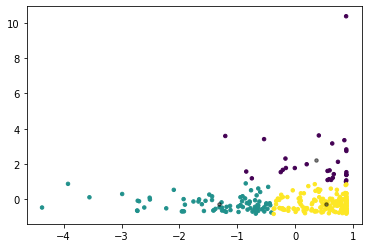

In [ ]:
plt.scatter(data_scaled[:, 0], data_scaled[:, 1], c=y_kmeans, s=12, cmap='viridis')

centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=12, alpha=0.5)

# **Silhouette score of K-means clustering**

In [ ]:
#calculating silhouette score with 3 clusters
from sklearn.metrics import silhouette_score
print(f'Silhouette Score(n=3): {silhouette_score(data_scaled, y_kmeans)}')

Silhouette Score(n=3): 0.523451108850259


# **calinski_harabasz_score for K-means**

In [ ]:
from sklearn.metrics import calinski_harabasz_score
calinski_harabasz_score(data_scaled, y_kmeans)

231.34412204332176

# **davies_bouldin_score for K-means**

In [ ]:
from sklearn.metrics import davies_bouldin_score
davies_bouldin_score(data_scaled, y_kmeans)

0.6908376495519818

# **GMM**

In [ ]:
from sklearn.mixture import GaussianMixture
gmm = GaussianMixture(n_components=3)
gmm.fit(data_scaled)

GaussianMixture(covariance_type='full', init_params='kmeans', max_iter=100,
                means_init=None, n_components=3, n_init=1, precisions_init=None,
                random_state=None, reg_covar=1e-06, tol=0.001, verbose=0,
                verbose_interval=10, warm_start=False, weights_init=None)

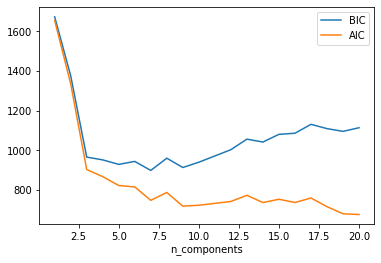

In [ ]:
from sklearn import mixture
n_components = np.arange(1, 21)
models = [mixture.GaussianMixture(n, covariance_type='full', random_state=0).fit(data_scaled)
          for n in n_components]

plt.plot(n_components, [m.bic(data_scaled) for m in models], label='BIC')
plt.plot(n_components, [m.aic(data_scaled) for m in models], label='AIC')
plt.legend(loc='best')
plt.xlabel('n_components');

In [ ]:
#predictions from gmm
labels = gmm.predict(data_scaled)
frame = pd.DataFrame(data_scaled)
frame['cluster'] = labels
frame.columns = ['user_id', 'price', 'cluster']

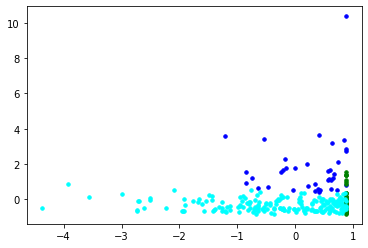

In [ ]:
color=['blue','green','cyan']
for k in range(0,3):
    data = frame[frame["cluster"]==k]
    plt.scatter(data["user_id"],data["price"],c=color[k], s=12)
plt.show()

# **Silhouette score of GMM clustering**

In [ ]:
#calculating silhouette score with 3 clusters
from sklearn.metrics import silhouette_score
print(f'Silhouette Score(n=3): {silhouette_score(data_scaled, labels)}')

Silhouette Score(n=3): 0.12111914281419185


# **calinski_harabasz_score for GMM**

In [ ]:
from sklearn.metrics import calinski_harabasz_score
calinski_harabasz_score(data_scaled, labels)

79.43743359495102

# **davies_bouldin_score for GMM**

In [ ]:
from sklearn.metrics import davies_bouldin_score
davies_bouldin_score(data_scaled, labels)

1.085960353512334

# **BIRCH**

In [ ]:
from sklearn.cluster import Birch
brc = Birch(branching_factor=100, n_clusters=3, threshold=0.5, compute_labels=True, copy=True)
brc.fit(data_scaled)

Birch(branching_factor=100, compute_labels=True, copy=True, n_clusters=3,
      threshold=0.5)

In [ ]:
labels = brc.predict(data_scaled)

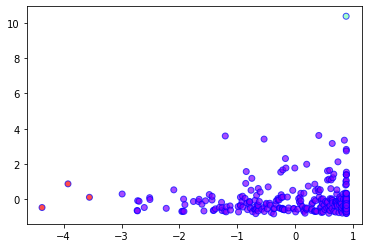

In [ ]:
plt.scatter(data_scaled[:,0], data_scaled[:,1], c=labels, cmap='rainbow', alpha=0.7, edgecolors='b')

# **Silhouette score of Birch clustering**

In [ ]:
#calculating silhouette score with 3 clusters
from sklearn.metrics import silhouette_score
print(f'Silhouette Score(n=3): {silhouette_score(data_scaled, labels)}')

Silhouette Score(n=3): 0.6123334940423968


# **calinski_harabasz_score of Birch clustering**



In [ ]:
from sklearn.metrics import calinski_harabasz_score
calinski_harabasz_score(data_scaled, labels)

52.823586666789744

# **davies_bouldin_score of Birch clustering**


In [ ]:
from sklearn.metrics import davies_bouldin_score
davies_bouldin_score(data_scaled, labels)

0.30980348220091636